When using a time series model, things to consider are:

1. Is it stationary?
2. Is there seasonality?
3. Is the target variable autocorrelated?

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from statsmodels.tsa.stattools import adfuller, acf, pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing train and test data

apple_news_data = pd.read_csv("AppleNewsStock.csv",index_col=0,parse_dates=True)
apple_train_data = pd.read_csv("AAPL.csv",index_col=0,parse_dates=True)
apple_test_data = pd.read_csv("AAPL_test.csv",index_col=0,parse_dates=True)

print("Shape of Apple News data",apple_news_data.shape)
print("Shape of Apple Train data",apple_train_data.shape)
print("Shape of Apple Test data",apple_test_data.shape)

Shape of Apple News data (2517, 7)
Shape of Apple Train data (10272, 6)
Shape of Apple Test data (22, 6)


In [3]:
#checking for NULL values

apple_news_data.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
News         194
dtype: int64

In [4]:
apple_train_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
apple_test_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
#Filtering data required

apple_news = apple_news_data[["News"]]
apple_train = apple_train_data[["Adj Close"]]
apple_test = apple_test_data[["Adj Close"]]

#Extracting only 10 years worth of data

apple_train = apple_train['2013-01-01':'2021-09-08']

In [29]:
apple_news.head()

,News
Date,
2006-12-01,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...
2006-12-04,More on Housing Prices : The broadest governme...
2006-12-05,NaN
2006-12-06,Honoring R.W. Apple in Words and Food : About ...
2006-12-07,"Homebuilders, and Worries Over Jobs, Lead a De..."


In [8]:
apple_train.head()

,Adj Close
Date,
2013-01-02,16.985447
2013-01-03,16.771053
2013-01-04,16.303900
2013-01-07,16.207998
2013-01-08,16.251616


In [9]:
apple_test.head()

,Adj Close
Date,
2021-09-09,153.649719
2021-09-10,148.563614
2021-09-13,149.142044
2021-09-14,147.715927
2021-09-15,148.623444


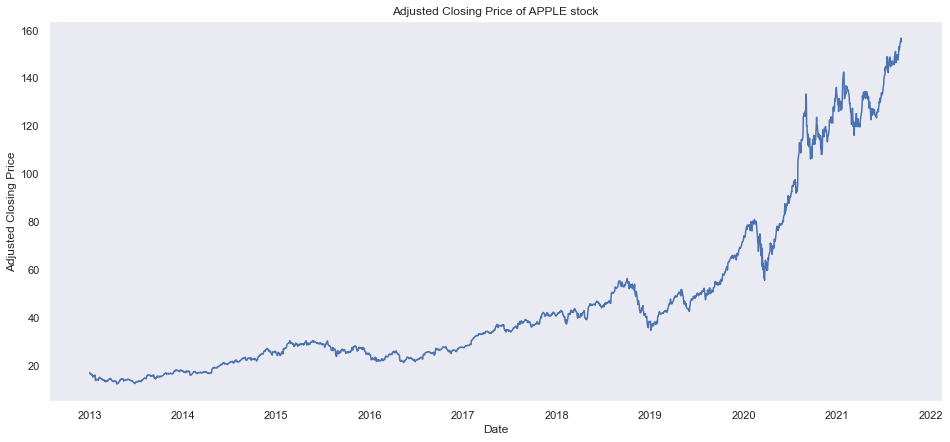

In [10]:
#Plotting the graph

plt.figure(figsize=(16,7))
plt.plot(apple_train)
plt.title('Adjusted Closing Price of APPLE stock')
plt.ylabel('Adjusted Closing Price')
plt.xlabel('Date')
plt.grid(False)
plt.show()

From the graph, we can tell that it is not stationary but we are unable to tell whether it has seasonality.

In [11]:
#Using moving average to smoothen the time series graph

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(16,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

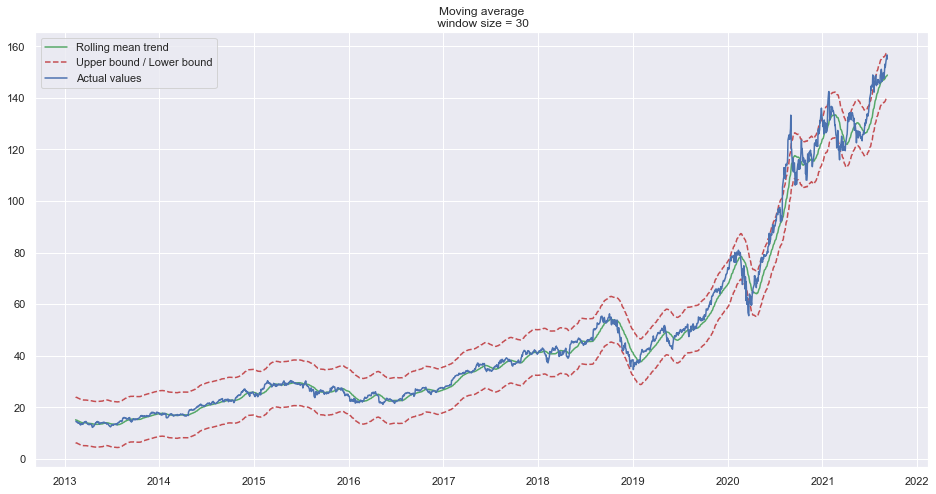

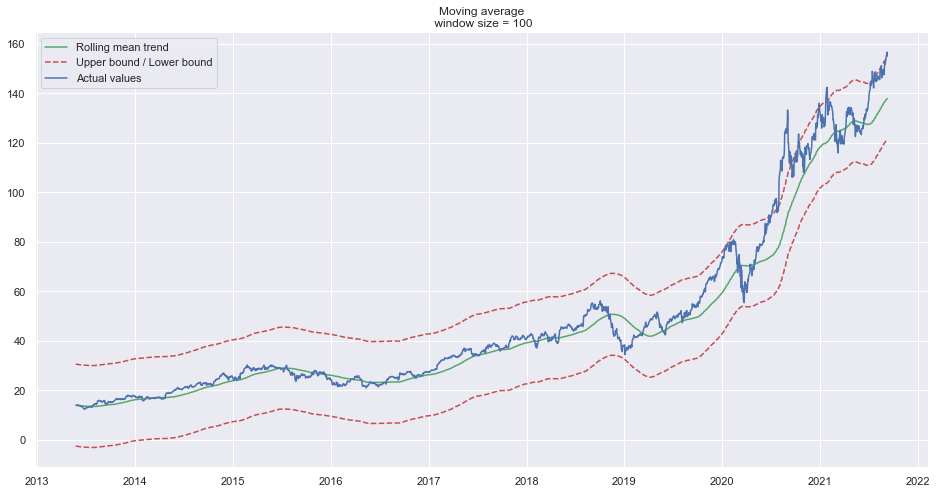

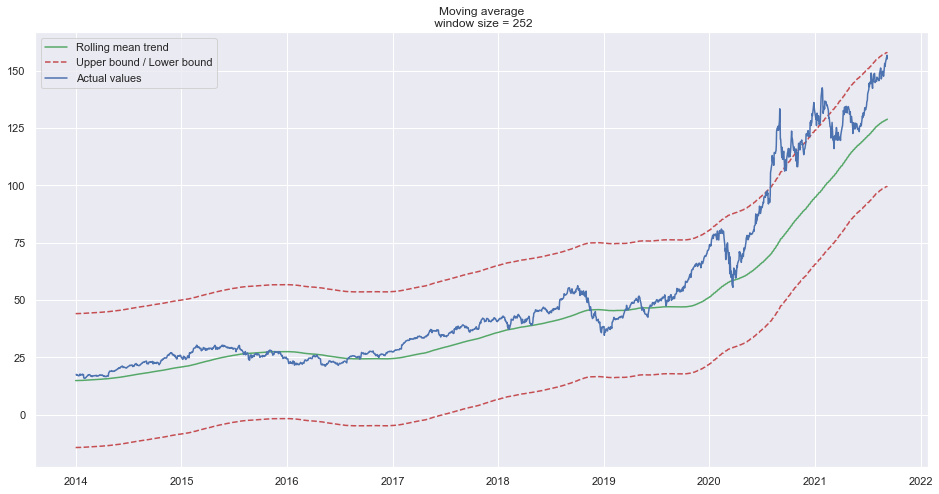

In [17]:
#Smoothing it by 30 days

plot_moving_average(apple_train, 30, plot_intervals=True)

#Smoothing it by 100 days

plot_moving_average(apple_train, 100, plot_intervals=True)

#Smoothing it by 1 year

plot_moving_average(apple_train, 252, plot_intervals=True)

Using the 30-day trend, we are unable to see a trend happening as the the moving average is too close to the graph.

Using the 100-day and 1-year trends, we can see that the trend has been increasing over the years and is likely to continue increasing in the future as the curve continues trend upwards at the end.

In [58]:
#Dickey-Fuller function

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. Num of Lags : ",dftest[2])
    print("4. Num of Observations Used for ADF Regression and Critical Values Calculation : ",dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t",key,": ",val)

In [59]:
#Using Dickey-Fuller test to show whether the model stationary

ad_test(apple_train)

1. ADF :  2.7297153327290977
2. P-Value :  0.9990880080721897
3. Num of Lags :  26
4. Num of Observations Used for ADF Regression and Critical Values Calculation :  2160
5. Critical Values : 
	 1% :  -3.4333810594081227
	 5% :  -2.862879013318124
	 10% :  -2.5674828242884087


In [66]:
#Using ACF to test for seasonality

lag_acf = acf(apple_train,nlags=40)
lag_pacf = pacf(apple_train,nlags=40)

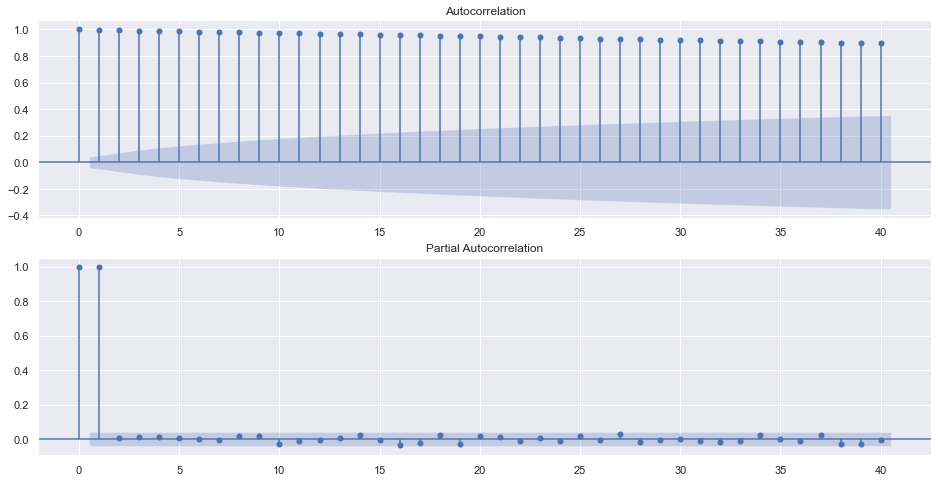

In [68]:
import statsmodels.api as sm
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(apple_train,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(apple_train,lags=40,ax=ax2)

From the Dickey-Fuller test, the time series is not stationary due to its high P-Value. Also from the autocorrelation plot, there is no clear seasonality.

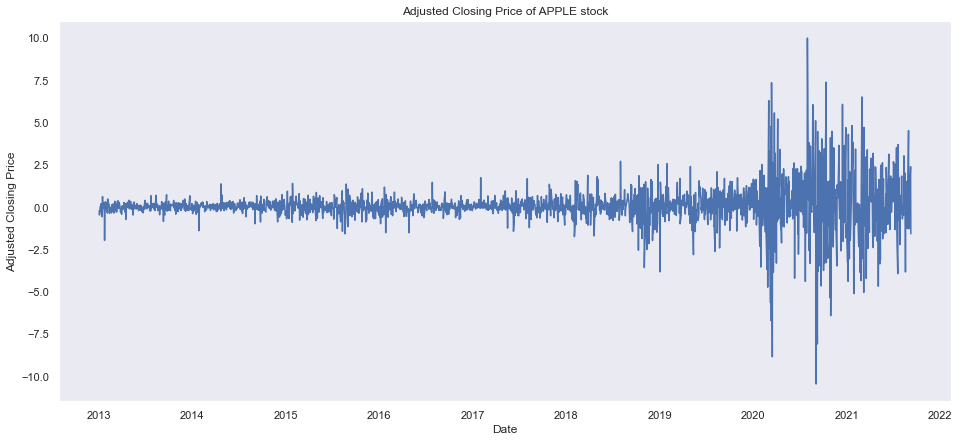

In [70]:
#Differencing the model

apple_train_diff = apple_train - apple_train.shift(1)

plt.figure(figsize=(16,7))
plt.plot(apple_train_diff.dropna())
plt.title('Adjusted Closing Price of APPLE stock')
plt.ylabel('Adjusted Closing Price')
plt.xlabel('Date')
plt.grid(False)
plt.show()

In [72]:
#Testing whether the model is stationary

ad_test(apple_train_diff.dropna())

1. ADF :  -9.359847067137858
2. P-Value :  7.876824469634825e-16
3. Num of Lags :  26
4. Num of Observations Used for ADF Regression and Critical Values Calculation :  2159
5. Critical Values : 
	 1% :  -3.4333824650008378
	 5% :  -2.862879633943035
	 10% :  -2.5674831547315


In [73]:
#Using ACF to test for seasonality

lag_acf = acf(apple_train_diff.dropna(),nlags=40)
lag_pacf = pacf(apple_train_diff.dropna(),nlags=40)

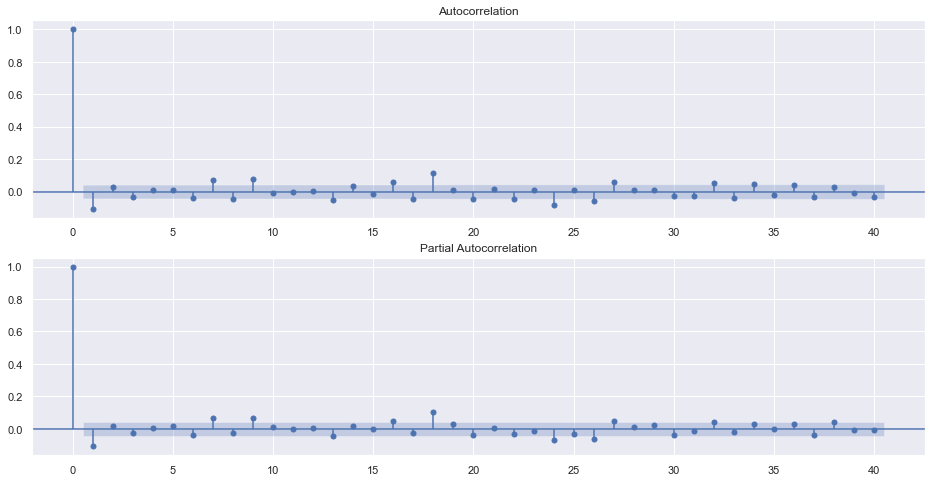

In [74]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(apple_train_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(apple_train_diff.dropna(),lags=40,ax=ax2)

The time series is now stationary.

In [76]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [91]:
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(apple_train, order=(param[0], d, param[1]),seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [92]:
result_table = optimize_SARIMA(parameters_list, d, D, s)
p, q, P, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(apple_train, order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

                                          SARIMAX Results                                           
Dep. Variable:                                    Adj Close   No. Observations:                 2187
Model:             SARIMAX(1, 1, 2)x(3, 1, [1, 2, 3, 4], 5)   Log Likelihood                 -44.051
Date:                                      Sat, 26 Mar 2022   AIC                            110.102
Time:                                              00:36:31   BIC                            172.665
Sample:                                                   0   HQIC                           132.974
                                                     - 2187                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   1.18e-08  

SARIMA values (1, 1, 2)x(3, 1, [1, 2, 3, 4], 5)

In [109]:
#Predicting future values

model = sm.tsa.statespace.SARIMAX(apple_train, order=(1,1,2), seasonal_order=(3,1,3,5)).fit()

start = len(apple_train)
end = len(apple_train)+len(apple_test)-1
prediction = model.predict(start=start,end=end,typ='levels')
prediction.index = apple_test.index
print(prediction)

Date
2021-09-09    155.031976
2021-09-10    154.543727
2021-09-13    154.556346
2021-09-14    154.907005
2021-09-15    154.847386
2021-09-16    155.138877
2021-09-17    155.758768
2021-09-20    155.931136
2021-09-21    155.838757
2021-09-22    155.910262
2021-09-23    155.600322
2021-09-24    155.360445
2021-09-27    155.309580
2021-09-28    155.376298
2021-09-29    155.701439
2021-09-30    155.826789
2021-10-01    156.126377
2021-10-04    156.256372
2021-10-05    156.443061
2021-10-06    156.217699
2021-10-07    156.157482
2021-10-08    156.340914
Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='Date'>

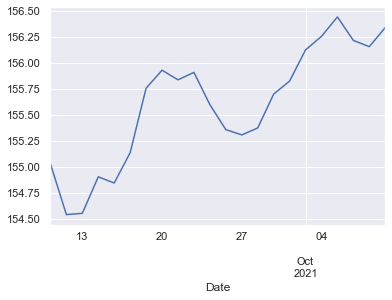

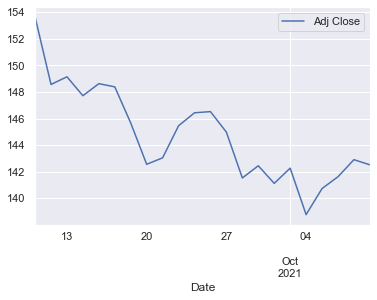

In [110]:
prediction.plot()
apple_test.plot()